In [8]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wandb

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

from patterns.dataset import ModularArithmetic, Operator
from patterns.transformer import Transformer
from patterns.utils import generate_run_name
from patterns.learner import Config

from toy_models.fit import rescale_run, Pattern, PatternLearningModel

from unifying.sweep import get_history, handle_outliers
from unifying.plotting import BLUE, RED

DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [9]:
from contextlib import suppress
from copy import deepcopy
from dataclasses import asdict, dataclass
from datetime import datetime
from typing import Callable, List, Literal, Optional, Tuple, Union

import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from matplotlib.colors import LogNorm
from torch import nn, optim
from tqdm.notebook import tqdm

import wandb


def rescale_run(run, new_max=1.0, log=True):
    # Changes the steps to fit in the range [0, 100] (following a log scale)
    run = run.copy()
    max_ = run["_step"].max()

    if log:
        max_ = np.log(max_)
        run["_step"] = np.log(run["_step"]) / max_ * new_max
    else:
        run["_step"] = run["_step"] / max_ * new_max

    return run


class Pattern(nn.Module):
    def __init__(self, max_time: float = 1.0, onset: Optional[float] = None, generalization: Optional[float] = None, strength: Optional[float] = None, speed: Optional[float] = None):
        # 4 scalar parameters: strength, speed, onset, generalization
        super().__init__()

        strength = strength or torch.rand(1)[0]
        speed = speed or torch.rand(1)[0] * 10 / max_time
        onset = onset or torch.rand(1)[0] * max_time
        generalization = generalization or torch.rand(1)[0]

        self._strength = nn.Parameter(self._inv_sigmoid(torch.tensor(strength)))
        self.speed = nn.Parameter(torch.tensor(speed))
        self.onset = nn.Parameter(torch.tensor(onset))
        self._generalization = nn.Parameter(torch.log(torch.tensor(generalization)))

    @staticmethod
    def _inv_sigmoid(x):
        return torch.log(x / (1 - x))
    
    @property
    def strength(self):
        return F.sigmoid(self._strength)
    
    @strength.setter
    def strength(self, value):
        self._strength = self._inv_sigmoid(value)

    @property
    def generalization(self):
        return torch.exp(self._generalization)
    
    @generalization.setter
    def generalization(self, value):
        self._generalization = torch.log(value)

    def forward(self, t):
        return self.strength * F.sigmoid(self.speed * (t - self.onset))

    def __repr__(self):
        return f"Pattern(strength={self.strength.data.float()}, speed={self.speed.data.float()}, onset={self.onset.data.float()}, generalization={self.generalization.data.float()})"


class PatternLearningModel(nn.Module):
    def __init__(self, num_patterns: int = 3, max_time=1.0):
        super().__init__()
        self.num_patterns = num_patterns
        self.patterns = nn.ModuleList([
            Pattern(
                max_time, 
                onset=max_time * (i + 1) / (num_patterns + 1),
                speed=10./max_time,
                generalization=0.5,
                strength=0.5
            ) 
            for i in range(num_patterns)
        ])
        self.max_time = max_time

        self.binary_mask = torch.tensor(
            [
                [int(i) for i in bin(j)[2:].zfill(num_patterns)]
                for j in range(2**num_patterns)
            ]
        ).float()

        self.counts = self.binary_mask.sum(dim=1)

    def forward(self, t):
        return 1 - torch.prod(1 - self.predictivenesses(t), dim=0)

    # def usages(self, t):
    #     preds = self.predictivenesses(t)
    #     usages = torch.prod(preds.T * self.binary_mask + (1 - preds.T) * (1 - self.binary_mask), dim=1)
    #     return usages

    def gs(self):
        return torch.stack([p.generalization for p in self.patterns])

    # def generalizations(self):
    #     generalizations = torch.sum(self.gs().T * self.binary_mask, dim=1) / self.counts
    #     generalizations[0] = 0
    #     return generalizations

    def predictivenesses(self, t):
        return torch.stack([p(t) for p in self.patterns])

    def forward(self, t):
        prod = 1

        for p in self.patterns:
            prod *= 1 - p(t)

        return 1 - prod

    def usages(self, t):
        preds = [p(t) for p in self.patterns]
        usages = torch.ones(2**self.num_patterns)

        for i in range(2**self.num_patterns):
            for j in range(self.num_patterns):
                if i & (1 << j):
                    usages[i] *= preds[j]
                else:
                    usages[i] *= 1 - preds[j]

        return usages

    def generalizations(self):
        generalizations = torch.zeros(2**self.num_patterns)

        for i in range(2**self.num_patterns):
            count = 0
            total = 0

            for j in range(self.num_patterns):
                if i & (1 << j):
                    # print(i, j, self.patterns[j].generalization, generalizations[i])
                    generalizations[i] += self.patterns[j].generalization
                    count += 1
                
                total += self.patterns[j].generalization

            # if count > 0:
            #     generalizations[i] /= count

            if total > 0:
                generalizations[i] /= total

        return generalizations

    def test(self, t):
        return torch.sum(self.generalizations() * self.usages(t), dim=0)

    def fit(self, run, lr=0.1, num_epochs=1000, callback=None, callback_ivl=100):
        ts = torch.tensor(run._step.values).float()

        train_ys = torch.tensor(run["train/acc"].values).float()
        test_ys = torch.tensor(run["test/acc"].values).float()

        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        # Cross-entropy
        eps = 1e-6
        # criterion = lambda preds, ys: -torch.sum(ys * torch.log(preds + eps) + (1 - ys) * torch.log(1 - preds + eps))
        callback(self)

        for epoch in tqdm(range(num_epochs)):
            train_preds = torch.zeros_like(train_ys)
            test_preds = torch.zeros_like(test_ys)

            optimizer.zero_grad()

            for i, t in enumerate(ts):
                train_preds[i] = self(t)
                test_preds[i] = self.test(t)

            loss = criterion(train_preds, train_ys) + criterion(test_preds, test_ys)
            loss.backward()
            optimizer.step()

            print(f"Epoch {epoch} - loss: {loss.item()}")
            
            if callback is not None and epoch % callback_ivl == 0:
                callback(self)

        return self

    def to_dict(self):
        """To a dataframe, sorting patterns by onset time"""
        patterns = sorted(self.patterns, key=lambda p: p.onset.data)
        d = {}

        for i, p in enumerate(patterns):
            d[f"pattern_{i}/strength"] = p.strength.data
            d[f"pattern_{i}/speed"] = p.speed.data
            d[f"pattern_{i}/onset"] = p.onset.data
            d[f"pattern_{i}/generalization"] = p.generalization.data

        return d
    
    def rescale(self, max_time):
        """Rescale the model to a new max time"""
        scaling_factor = max_time / self.max_time

        for p in self.patterns:
            p.onset.data /= scaling_factor
            p.speed.data *= scaling_factor

        self.max_time = max_time

    def __repr__(self):
        return f"PatternLearningModel({self.to_dict()})"


In [10]:
torch.manual_seed(2)
pl_model = PatternLearningModel(max_time=100.)

def plot_patterns(pl_model, run):
    ts = run["_step"].values
    train_preds = [pl_model(t).detach().numpy() for t in ts]
    test_preds = [pl_model.test(t).detach().numpy() for t in ts]
    train_ys = torch.tensor(run["train/acc"].values).float()
    test_ys = torch.tensor(run["test/acc"].values).float()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(ts, train_preds, label="train", color="blue")
    axes[0].plot(ts, test_preds, label="test", color="red")

    axes[1].plot(ts, train_ys, label="train", color="blue")
    axes[1].plot(ts, test_ys, label="test", color="red")

    axes[0].set_title("Predictions")
    axes[1].set_title("True values")

    # axes[0].set_xscale("log")
    # axes[1].set_xscale("log")

In [11]:
VARIABLE_COLS = [
    "test/acc",
    "train/acc",
    "test/loss",
    "train/loss",
    "_step",
    "weight/norm",
    "test/efficiency",
    "train/efficiency",
    "weight/dist_from_init",
    "weight/cos_sim_with_init",
]

def fit_sweep(df: pd.DataFrame, unique_col: str, lr=0.1, max_time=1.0, num_patterns=3, num_epochs=500, **kwargs):
    unique_vals = df.loc[:, unique_col].unique()

    variable_cols = [c for c in df.columns if c in VARIABLE_COLS]
    hyperparams: dict = (
        df.loc[0, :]
        .drop(columns=[unique_col, *variable_cols])
        .to_dict()
    )

    wandb.init(
        project="fit-toy-model",
    )

    try:
        for unique_val in tqdm(unique_vals):
            run = df.loc[df[unique_col] == unique_val]
            rescaled_run = rescale_run(run, new_max=max_time)

            pl_model = PatternLearningModel(
                num_patterns=num_patterns, 
                max_time=max_time
            )

            def _plot_patterns(pl_model):
                plot_patterns(pl_model, rescaled_run)
                plt.show()

            pl_model.fit(rescaled_run, lr=lr, num_epochs=num_epochs, callback=_plot_patterns)
            pl_model.rescale(1.)

            wandb.log({unique_col: unique_val, **pl_model.to_dict(), **hyperparams, **kwargs})

            _plot_patterns(pl_model)
            plt.show()

    except KeyboardInterrupt:
        wandb.finish()


In [6]:
INTERP_SWEEPS = ["kodd01ka", "wecya83q", "wqnakkjd"]  # "awxzpem1"
interp_sweep = get_history(*INTERP_SWEEPS, project="mnist-grokking", allow_duplicates=True, combine_seeds=True)
# interp_sweep.drop(["weight/cos_sim_with_init", "test/efficiency", "train/efficiency", "weight/dist_from_init"])
interp_sweep

,_step,test/acc,train/acc,weight/cos_sim_with_init,_timestamp,test/efficiency,weight/dist_from_init,test/loss,train/loss,_runtime,...,num_classes,log_interval,weight_decay,frac_label_noise,num_training_steps,test_acc_criterion,corrupted/acc,corrupted/loss,uncorrupted/acc,uncorrupted/loss
0,1,0.114477,0.099918,1.000000,1.684057e+09,138.675528,0.000000,7592.346436,7668.214716,1.710270,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
2,2,0.099800,0.095975,0.999944,1.684030e+09,21.788515,0.779714,2570.959518,2614.968656,1.941859,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
3,3,0.109166,0.108092,1.000000,1.684035e+09,135.244055,0.009360,4200.766150,4192.602378,1.928966,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
4,4,0.103507,0.103365,0.999763,1.684007e+09,42.881656,1.600768,2943.958030,2893.220456,2.154059,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
5,5,0.109581,0.092515,1.000000,1.684053e+09,135.095459,0.009200,2787.610881,2791.692159,1.975405,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,499500,0.431138,0.995010,0.407474,1.684012e+09,0.009685,94.084561,0.928285,0.013537,4838.263367,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
305,499600,0.194611,1.000000,0.993671,1.684039e+09,0.316138,8.603062,13.233299,0.001455,4473.957028,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
29,499700,0.293413,1.000000,0.533350,1.684035e+09,0.010370,74.662526,25.365513,0.000602,4573.060594,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
267,499900,0.149701,1.000000,0.995589,1.684057e+09,0.413519,7.259769,29.355416,0.000356,4496.706427,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN


# Fit the sweeps

In [20]:
# WD_SWEEP_ID = "ib21hnk1"
# LN_SWEEP_ID = "8783j1j4"
DM_SWEEP_ID = "l1b2mmci"

# dm_sweep_2 = pd.read_csv("../unifying/mw_sweep.csv")

SWEEP_IDS = ["interpolation"] # [WD_SWEEP_ID, LN_SWEEP_ID, DM_SWEEP_ID]
UNIQUE_COLS = ["lr_factor"] # ["weight_decay", "frac_label_noise", "d_model"]
SWEEPS = [interp_sweep] # [get_history(sweep_id, unique_cols=unique_col) for sweep_id, unique_col in zip(SWEEP_IDS, UNIQUE_COLS)]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland. Use `wandb login --relogin` to force relogin


  0%|          | 0/30 [00:00<?, ?it/s]

/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


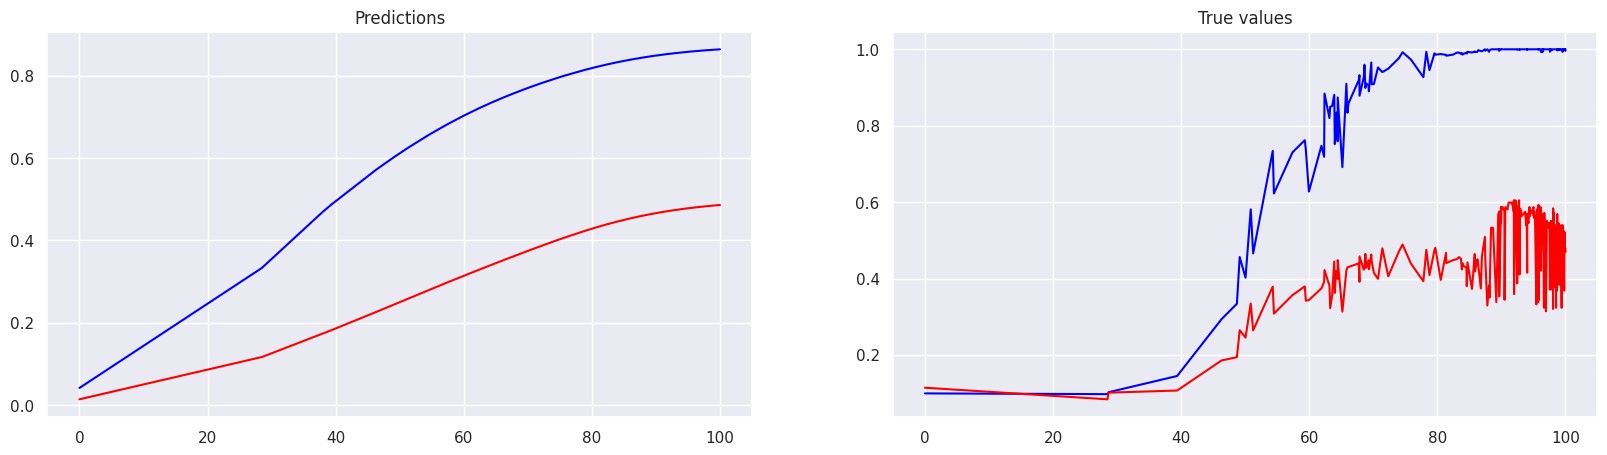

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.027295349165797234


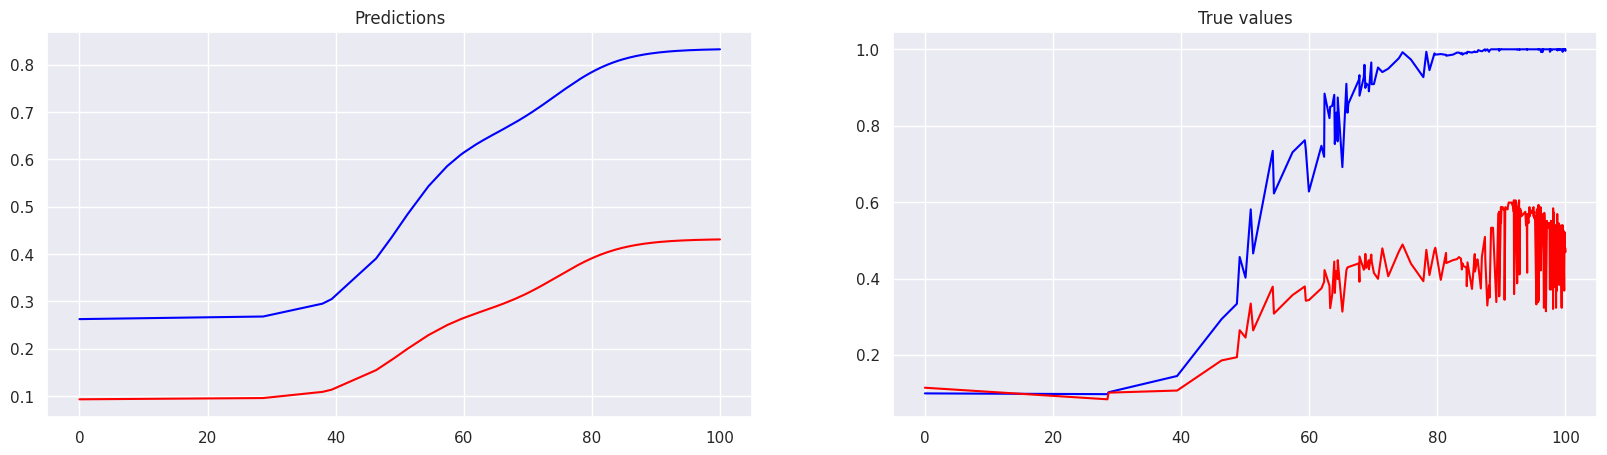

Epoch 1 - loss: 0.04233807697892189
Epoch 2 - loss: 0.016434835270047188
Epoch 3 - loss: 0.017488427460193634
Epoch 4 - loss: 0.018904440104961395
Epoch 5 - loss: 0.02002222277224064
Epoch 6 - loss: 0.020659156143665314
Epoch 7 - loss: 0.020827505737543106
Epoch 8 - loss: 0.020633505657315254
Epoch 9 - loss: 0.020205318927764893
Epoch 10 - loss: 0.019652940332889557
Epoch 11 - loss: 0.01906352862715721
Epoch 12 - loss: 0.01851528324186802
Epoch 13 - loss: 0.018076501786708832
Epoch 14 - loss: 0.017790254205465317
Epoch 15 - loss: 0.017661988735198975
Epoch 16 - loss: 0.017658010125160217
Epoch 17 - loss: 0.01771586760878563
Epoch 18 - loss: 0.01776360720396042
Epoch 19 - loss: 0.01774098351597786
Epoch 20 - loss: 0.017614547163248062
Epoch 21 - loss: 0.017382165417075157
Epoch 22 - loss: 0.017067115753889084
Epoch 23 - loss: 0.016706056892871857
Epoch 24 - loss: 0.01633581519126892
Epoch 25 - loss: 0.01598300039768219
Epoch 26 - loss: 0.015658579766750336
Epoch 27 - loss: 0.01535797957

In [7]:
for sweep, sweep_id, unique_col in zip(SWEEPS, SWEEP_IDS, UNIQUE_COLS): 
    fit_sweep(sweep, unique_col, num_patterns=3, max_time=100.0, log=True, sweep=sweep_id, num_epochs=500)

In [12]:
api = wandb.Api()
runs = api.runs(f"jqhoogland/fit-toy-model")
[run for run in runs]

[<Run jqhoogland/fit-toy-model/adwkvhjw (running)>,
 <Run jqhoogland/fit-toy-model/n35nig8t (running)>,
 <Run jqhoogland/fit-toy-model/qc4itmz1 (running)>,
 <Run jqhoogland/fit-toy-model/0v1thdzj (finished)>,
 <Run jqhoogland/fit-toy-model/1gthqqg5 (finished)>,
 <Run jqhoogland/fit-toy-model/5s56iliv (crashed)>]

In [28]:
mw_fit_run_id = "1gthqq5"
run = runs[2]
df = run.history()

col = "d_model"
unique_vals = df.loc[:, col].unique()
print(unique_vals)
df

[  1   2   3   4   5   6   8   9  11  14  17  20  25  30  37  44  54  65
  79  95 115 140 169 205 248 300]


,pattern_0/onset,_step,modulus,log,pattern_1/speed,d_vocab,num_training_steps,weight_decay,_runtime,sweep,...,frac_train,pattern_0/generalization,test_acc_criterion,embed_dim,num_ctx,batch_size,_timestamp,frac_label_noise,pattern_2/onset,d_head
0,1586.732178,0,113,True,-0.006830,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.213087,1,300,3,3830,1.683837e+09,0,7410.460938,32
1,1062.660767,1,113,True,-0.006865,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.264094,1,300,3,3830,1.683837e+09,0,7424.370117,32
2,1223.991821,2,113,True,-0.006661,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.299968,1,300,3,3830,1.683837e+09,0,7338.598145,32
3,1343.376587,3,113,True,-0.007134,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.199818,1,300,3,3830,1.683837e+09,0,8287.747070,32
4,1485.789429,4,113,True,-0.006551,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.373736,1,300,3,3830,1.683837e+09,0,7520.019531,32
5,1435.536377,5,113,True,-0.004474,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.188602,1,300,3,3830,1.683837e+09,0,7554.412109,32
6,1208.405396,6,113,True,-0.006050,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.638340,1,300,3,3830,1.683837e+09,0,6846.722656,32
7,1379.252686,7,113,True,-0.006602,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.036816,1,300,3,3830,1.683837e+09,0,9516.064453,32
8,2736.685059,8,113,True,0.005848,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.019606,1,300,3,3830,1.683837e+09,0,7656.134766,32
9,2740.774902,9,113,True,0.007786,114,100000,0.3,2.410218,l1b2mmci,...,0.4,0.024199,1,300,3,3830,1.683837e+09,0,7695.309570,32


In [35]:
def df_row_to_toy_model(row):
    model = PatternLearningModel(max_time=1.)

    for i, pattern in enumerate(model.patterns):
        pattern.onset.data = torch.tensor(row[f"pattern_{i}/onset"])
        pattern.speed.data = torch.tensor(row[f"pattern_{i}/speed"])
        pattern._strength.data = pattern._inv_sigmoid(torch.tensor(row[f"pattern_{i}/strength"]))  # type: ignore
        pattern._generalization.data = torch.log(torch.tensor(row[f"pattern_{i}/generalization"]))

    return model

D_MODEL = 115
co9l = "d_model"
model_entry = df.loc[df[col] == D_MODEL, :].iloc[0, :]
print(model_entry)
model = df_row_to_toy_model(model_entry)
model.rescale(100)
model.patterns

pattern_0/onset                   3307.669922
_step                                      20
modulus                                   113
log                                      True
pattern_1/speed                       0.00761
d_vocab                                   114
num_training_steps                     100000
weight_decay                              0.3
_runtime                             2.410218
sweep                                l1b2mmci
pattern_1/onset                   4938.347168
lr                                      0.001
seed                                        0
pattern_1/generalization             0.701577
pattern_2/generalization             6.939834
num_layers                                  1
log_interval                               10
pattern_1/strength                     0.9862
pattern_0/strength                   0.077263
pattern_0/speed                      0.004219
d_model                                   115
pattern_2/strength                

/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ModuleList(
  (0): Pattern(strength=0.0772629827260971, speed=0.4218541085720062, onset=33.076698303222656, generalization=0.014402443543076515)
  (1): Pattern(strength=0.9861999750137329, speed=0.760972797870636, onset=49.38347244262695, generalization=0.7015765905380249)
  (2): Pattern(strength=0.9925130605697632, speed=0.5755707621574402, onset=75.50422668457031, generalization=6.939833641052246)
)

In [37]:
# Get corresponding original run
og_df = get_history(DM_SWEEP_ID, unique_cols="d_model")
run = og_df.loc[og_df.d_model==D_MODEL,:] #.plot(x="_step", y="test/acc")

/tmp/ipykernel_39642/2223921967.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(["", "", "", "", "", ""], color="white")
/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_39642/2223921967.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])


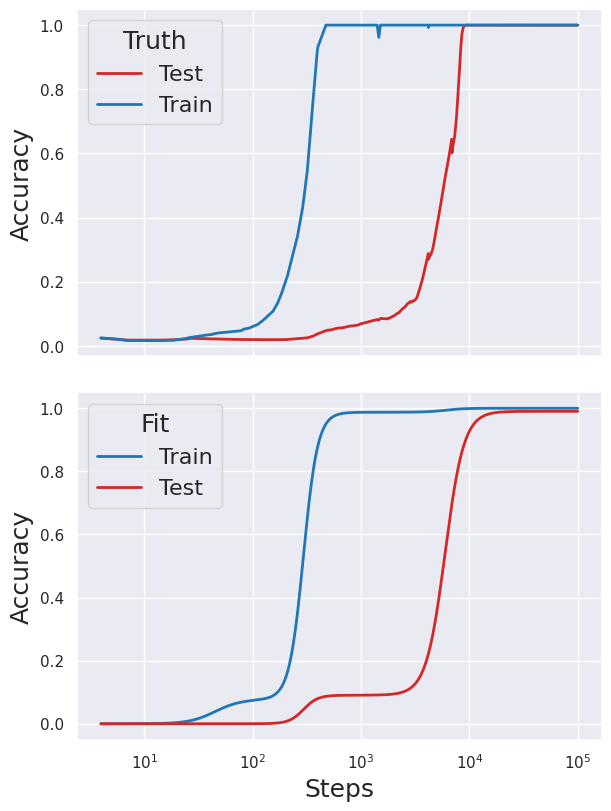

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

ax1.plot(run["_step"], run["test/acc"], label="Test", color=RED, linewidth=2)
ax1.plot(run["_step"], run["train/acc"], label="Train", color=BLUE, linewidth=2)
ax1.set_ylabel("Accuracy", fontsize=18)
# ax1.set_xlabel("Steps", fontsize=18)
ax1.set_xticklabels(["", "", "", "", "", ""], color="white")
ax1.set_xscale("log")
ax1.legend(title="Truth", fontsize=16, title_fontsize=18)

min_step, max_step = og_df["_step"].min(), 100 # run["_step"].max()

ts = np.linspace(12, max_step, 1000)
train_ys = [model(t).detach().numpy() for t in ts]
test_ys = [model.test(t).detach().numpy() for t in ts]
ax2.plot(ts, train_ys, label="Train", color=BLUE, linewidth=2)
ax2.plot(ts, test_ys, label="Test", color=RED, linewidth=2)
ax2.set_ylabel("Accuracy", fontsize=18)
ax2.set_xlabel("Steps", fontsize=18)
# ax2.set_title("Fit", )
ax2.legend(title="Fit", fontsize=16, title_fontsize=18)

ax2.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])
# ax2.set_xlim(10, 100)

fig.tight_layout(pad=0.25)

# Already in log scale
# train_ys, test_ys

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

ax1.plot(run["_step"], run["test/acc"], label="Test", color=RED, linewidth=2)
ax1.plot(run["_step"], run["train/acc"], label="Train", color=BLUE, linewidth=2)
ax1.set_ylabel("Accuracy", fontsize=18)
# ax1.set_xlabel("Steps", fontsize=18)
ax1.set_xticklabels(["", "", "", "", "", ""], color="white")
ax1.set_xscale("log")
ax1.legend(title="Truth", fontsize=16, title_fontsize=18)

min_step, max_step = og_df["_step"].min(), 100 # run["_step"].max()

ts = np.linspace(12, max_step, 1000)
train_ys = [model(t).detach().numpy() for t in ts]
test_ys = [model.test(t).detach().numpy() for t in ts]
ax2.plot(ts, train_ys, label="Train", color=BLUE, linewidth=2)
ax2.plot(ts, test_ys, label="Test", color=RED, linewidth=2)
ax2.set_ylabel("Accuracy", fontsize=18)
ax2.set_xlabel("Steps", fontsize=18)
# ax2.set_title("Fit", )
ax2.legend(title="Fit", fontsize=16, title_fontsize=18)
ax2.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])
# ax2.set_xlim(10, 100)

fig.tight_layout(pad=0.25)

# Already in log scale
# train_ys, test_ys

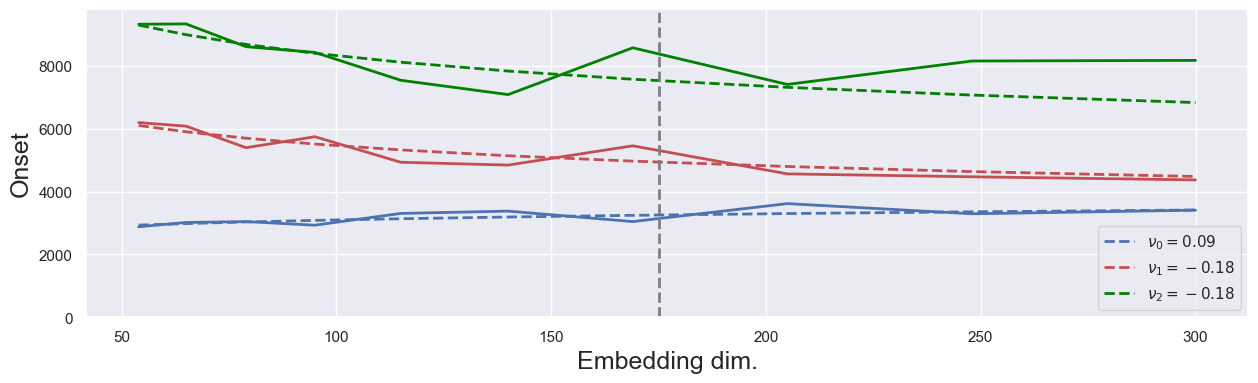

In [70]:
# Ignore any d_model < 50
df_cleaned = df.loc[df["d_model"] >= 50, :]
d_models = df_cleaned.loc[:, "d_model"].unique()

# Scaling analysis
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

colors = [BLUE, RED, "green"]
y_max = 0

for i in range(3):
    slice = df_cleaned.loc[:, f"pattern_{i}/onset"]
    y_max = max(y_max, slice.max())
    ax.plot(d_models, slice, label=f"", color=colors[i], linewidth=2)

ax.set_xlabel("d_model", fontsize=18)
ax.set_ylabel("Onset", fontsize=18)


# Fit a power-law to the onsets 
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * x**b

def fit_power_law(x, y):
    popt, pcov = curve_fit(power_law, x, y)
    return popt


CUTOFF = 175

# Fit power law to onset
for i in range(3):
    # Train up to a specific point
    df_to_fit = df_cleaned.loc[df_cleaned["d_model"] <= CUTOFF, :]
    d_models_to_fit = df_to_fit.loc[:, "d_model"].unique()

    onset_popt = fit_power_law(d_models_to_fit, df_to_fit.loc[:, f"pattern_{i}/onset"])
    exponent = round(onset_popt[1], 2)
    ax.plot(d_models, power_law(d_models, *onset_popt), label=f"$\\nu_{i} = {exponent}$", color=colors[i], linestyle="--", linewidth=2)

ax.vlines(CUTOFF, 0, y_max * 1.05, color="grey", linestyle="--", linewidth=2)
ax.set_xlabel("Embedding dim.", fontsize=18)
ax.set_ylim(0, y_max * 1.05)

ax.legend()

/tmp/ipykernel_39642/4264821536.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_to_decompose.sort_values(by="_step", inplace=True)
/tmp/ipykernel_39642/4264821536.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_to_decompose["test/acc"] = gaussian_filter1d(run_to_decompose["test/acc"], sigma=15)
/tmp/ipykernel_39642/4264821536.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

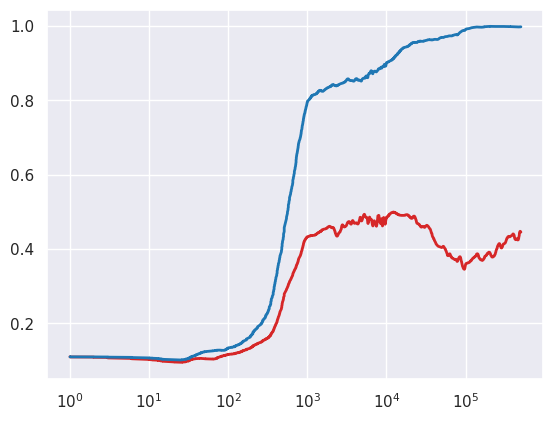

In [99]:
# Fit the model & show the pattern. 

run_to_decompose = interp_sweep.loc[interp_sweep.lr_factor == 5.5, :]
# Sort
run_to_decompose.sort_values(by="_step", inplace=True)
steps = run_to_decompose._step

# Apply a gaussian filter with sigma=2
from scipy.ndimage import gaussian_filter1d

run_to_decompose["test/acc"] = gaussian_filter1d(run_to_decompose["test/acc"], sigma=15)
run_to_decompose["train/acc"] = gaussian_filter1d(run_to_decompose["train/acc"], sigma=15)

plt.plot(steps, run_to_decompose["test/acc"], label="Test", color=RED, linewidth=2)
plt.plot(steps, run_to_decompose["train/acc"], label="Train", color=BLUE, linewidth=2)

plt.xscale("log")

run_to_decompose_rescaled = rescale_run(run_to_decompose, new_max=100)


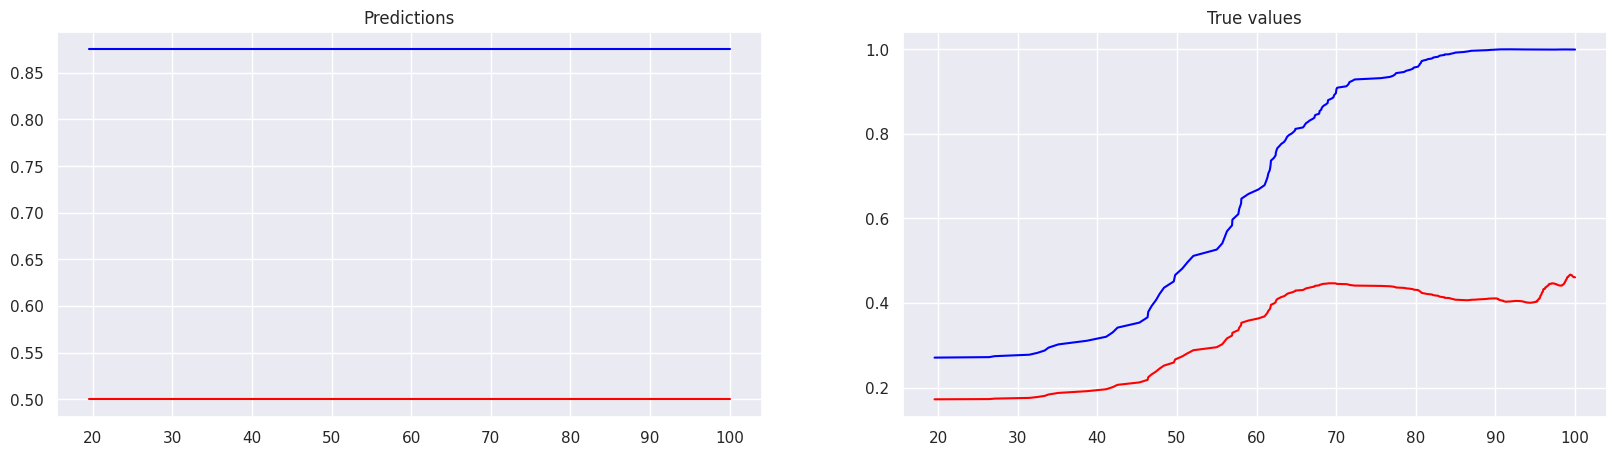

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - loss: 0.039858635514974594


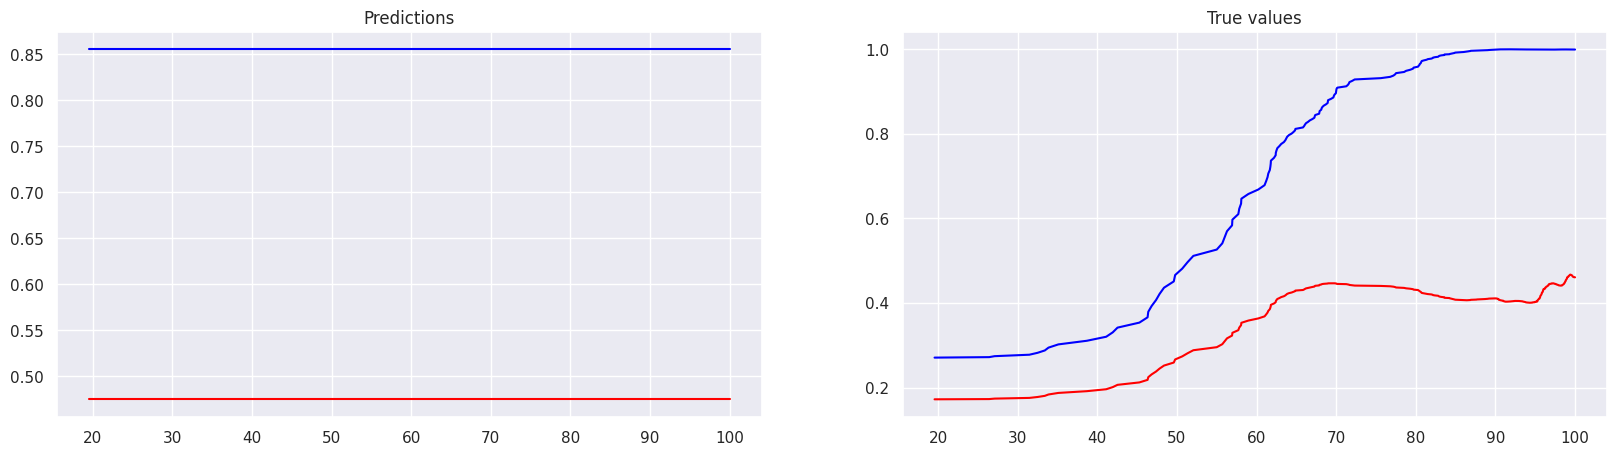

Epoch 1 - loss: 0.03857443481683731
Epoch 2 - loss: 0.03909042477607727
Epoch 3 - loss: 0.039265766739845276
Epoch 4 - loss: 0.03888075053691864
Epoch 5 - loss: 0.03856044262647629
Epoch 6 - loss: 0.038498394191265106
Epoch 7 - loss: 0.03841610625386238
Epoch 8 - loss: 0.03802547603845596
Epoch 9 - loss: 0.037287112325429916
Epoch 10 - loss: 0.03629075735807419
Epoch 11 - loss: 0.035145748406648636
Epoch 12 - loss: 0.033965788781642914
Epoch 13 - loss: 0.03289315104484558
Epoch 14 - loss: 0.032070208340883255
Epoch 15 - loss: 0.03153051808476448
Epoch 16 - loss: 0.03114066831767559
Epoch 17 - loss: 0.030748026445508003
Epoch 18 - loss: 0.030343100428581238
Epoch 19 - loss: 0.030026793479919434
Epoch 20 - loss: 0.02990177646279335
Epoch 21 - loss: 0.02999171055853367
Epoch 22 - loss: 0.03021114133298397
Epoch 23 - loss: 0.030416550114750862
Epoch 24 - loss: 0.03051588498055935
Epoch 25 - loss: 0.03052421286702156


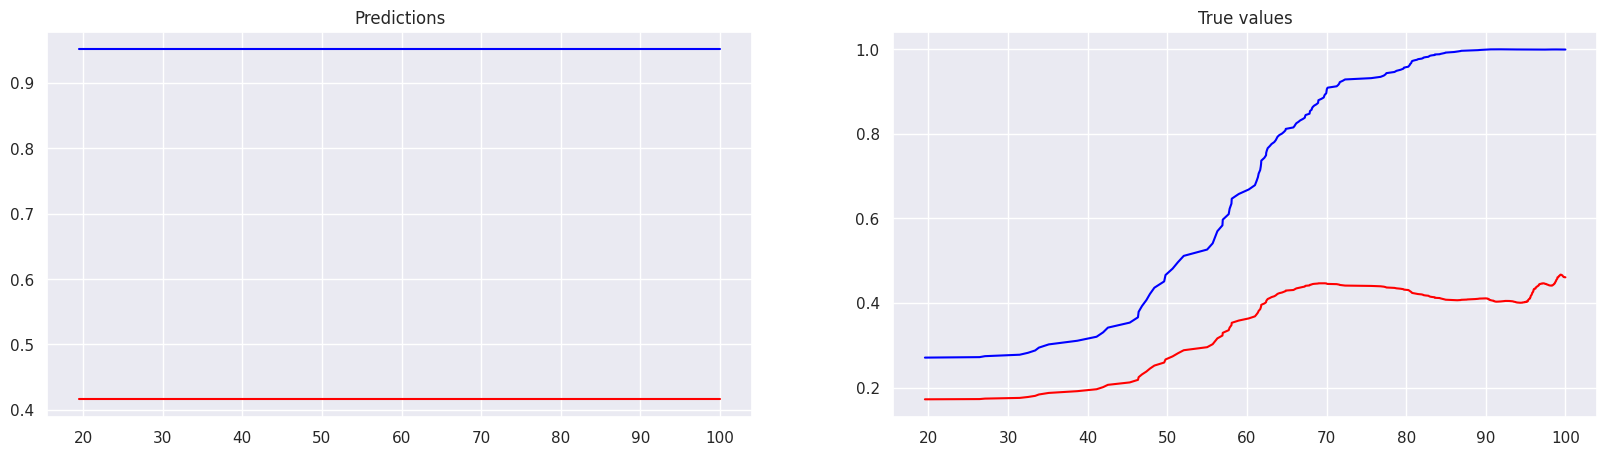

Epoch 26 - loss: 0.03051900491118431
Epoch 27 - loss: 0.030559193342924118
Epoch 28 - loss: 0.030638298019766808
Epoch 29 - loss: 0.030701184645295143
Epoch 30 - loss: 0.03070010244846344
Epoch 31 - loss: 0.03063318505883217
Epoch 32 - loss: 0.030537845566868782
Epoch 33 - loss: 0.030456120148301125
Epoch 34 - loss: 0.030402377247810364
Epoch 35 - loss: 0.030356958508491516
Epoch 36 - loss: 0.030290547758340836
Epoch 37 - loss: 0.030195388942956924
Epoch 38 - loss: 0.030092263594269753
Epoch 39 - loss: 0.03001013584434986
Epoch 40 - loss: 0.029961928725242615
Epoch 41 - loss: 0.0299382321536541
Epoch 42 - loss: 0.029920758679509163
Epoch 43 - loss: 0.029900139197707176
Epoch 44 - loss: 0.029881920665502548
Epoch 45 - loss: 0.02987818792462349
Epoch 46 - loss: 0.029894327744841576
Epoch 47 - loss: 0.029922882094979286
Epoch 48 - loss: 0.029949355870485306
Epoch 49 - loss: 0.029963528737425804
Epoch 50 - loss: 0.029965411871671677


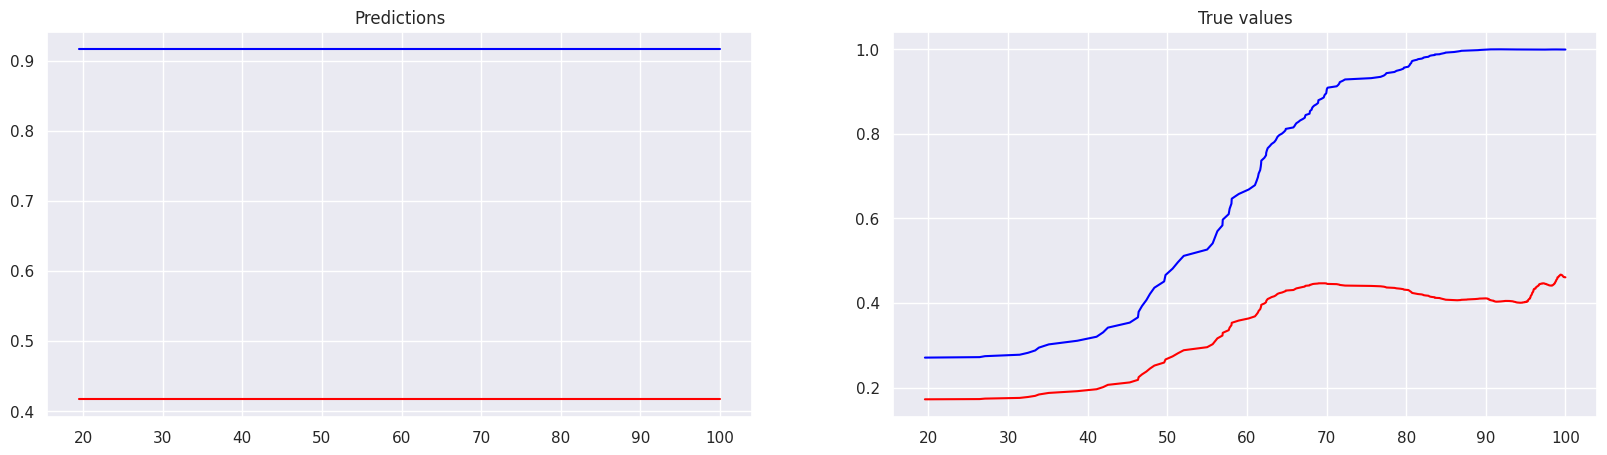

Epoch 51 - loss: 0.029961522668600082
Epoch 52 - loss: 0.029956942424178123
Epoch 53 - loss: 0.02995111234486103
Epoch 54 - loss: 0.029940379783511162
Epoch 55 - loss: 0.029923412948846817
Epoch 56 - loss: 0.029903750866651535
Epoch 57 - loss: 0.029887231066823006
Epoch 58 - loss: 0.029877347871661186
Epoch 59 - loss: 0.029873128980398178
Epoch 60 - loss: 0.02987128123641014
Epoch 61 - loss: 0.02986982837319374
Epoch 62 - loss: 0.029869478195905685
Epoch 63 - loss: 0.029871737584471703
Epoch 64 - loss: 0.029876401647925377
Epoch 65 - loss: 0.02988123893737793
Epoch 66 - loss: 0.029884010553359985
Epoch 67 - loss: 0.029884321615099907
Epoch 68 - loss: 0.02988344617187977
Epoch 69 - loss: 0.029882589355111122
Epoch 70 - loss: 0.02988165244460106
Epoch 71 - loss: 0.029879748821258545
Epoch 72 - loss: 0.02987658977508545
Epoch 73 - loss: 0.02987302839756012
Epoch 74 - loss: 0.029870260506868362
Epoch 75 - loss: 0.02986872009932995


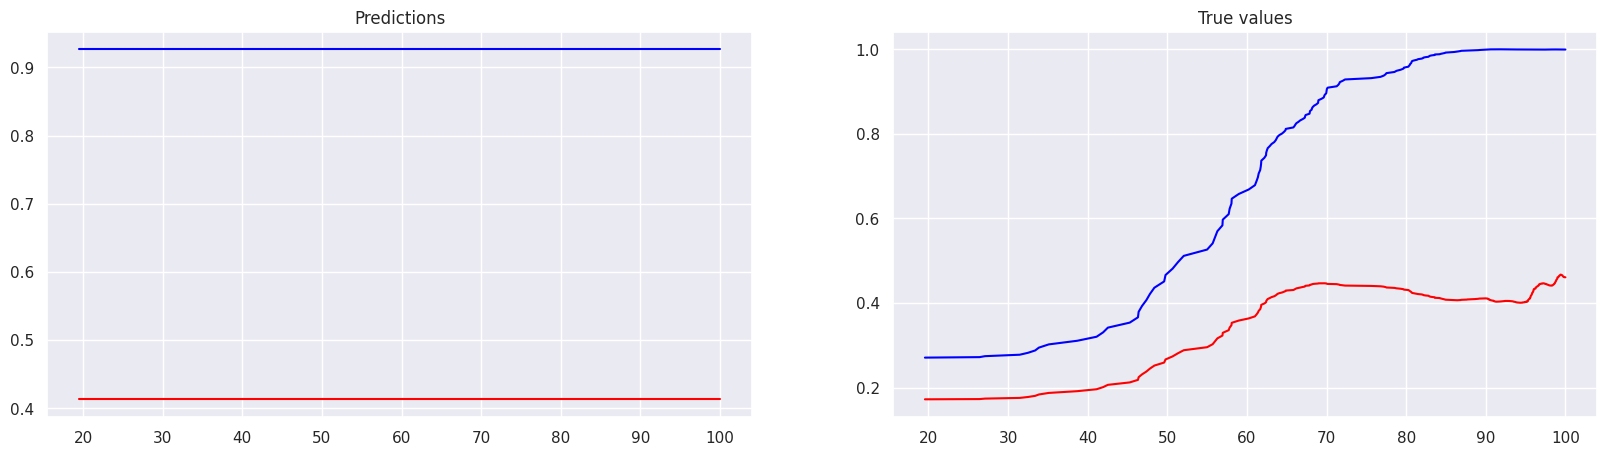

Epoch 76 - loss: 0.029867926612496376
Epoch 77 - loss: 0.02986728399991989
Epoch 78 - loss: 0.029866766184568405
Epoch 79 - loss: 0.029866792261600494
Epoch 80 - loss: 0.029867537319660187
Epoch 81 - loss: 0.0298685971647501
Epoch 82 - loss: 0.02986937388777733
Epoch 83 - loss: 0.02986963465809822
Epoch 84 - loss: 0.029869580641388893
Epoch 85 - loss: 0.029869485646486282
Epoch 86 - loss: 0.02986934222280979
Epoch 87 - loss: 0.02986895479261875
Epoch 88 - loss: 0.029868289828300476
Epoch 89 - loss: 0.029867546632885933
Epoch 90 - loss: 0.029867012053728104
Epoch 91 - loss: 0.029866736382246017
Epoch 92 - loss: 0.029866592958569527
Epoch 93 - loss: 0.029866471886634827
Epoch 94 - loss: 0.02986641228199005
Epoch 95 - loss: 0.029866499826312065
Epoch 96 - loss: 0.02986670844256878
Epoch 97 - loss: 0.029866913333535194
Epoch 98 - loss: 0.029867013916373253
Epoch 99 - loss: 0.029867012053728104


PatternLearningModel({'pattern_0/strength': tensor(0.6620), 'pattern_0/speed': tensor(10.), 'pattern_0/onset': tensor(0.2500), 'pattern_0/generalization': tensor(0.1706), 'pattern_1/strength': tensor(0.6624), 'pattern_1/speed': tensor(10.), 'pattern_1/onset': tensor(0.5000), 'pattern_1/generalization': tensor(0.1702), 'pattern_2/strength': tensor(0.3576), 'pattern_2/speed': tensor(10.), 'pattern_2/onset': tensor(0.7500), 'pattern_2/generalization': tensor(1.5037)})

In [87]:
model = PatternLearningModel()

def callback(x): 
    plot_patterns(x, run_to_decompose_rescaled)
    plt.show()

model.fit(run_to_decompose_rescaled, num_epochs=100, callback=callback, callback_ivl=25)

In [107]:
r_uncorrupted = gaussian_filter1d(run_to_decompose_rescaled["uncorrupted/acc"], sigma=2)
r_corrupted = gaussian_filter1d(run_to_decompose_rescaled["corrupted/acc"], sigma=2)

/tmp/ipykernel_39642/81126903.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "", "$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])


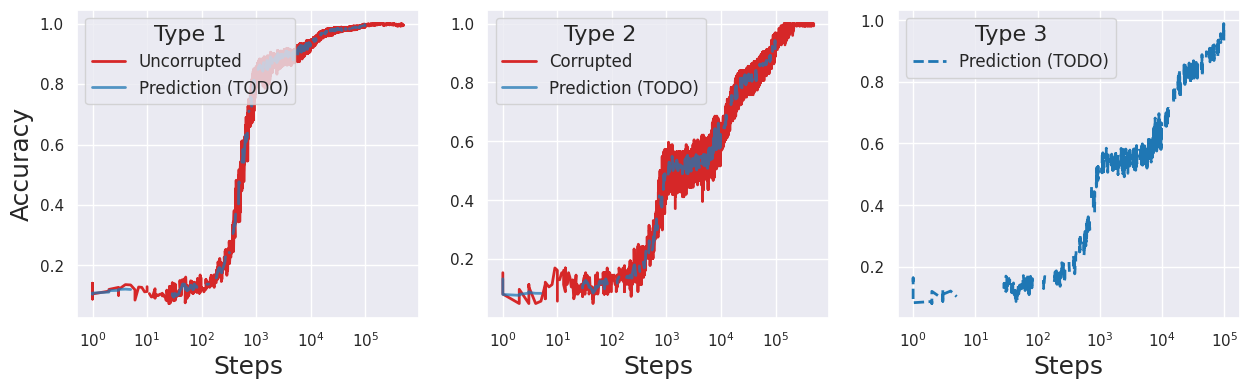

In [113]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Uncorrupted data / Type 1 Pattern
ax1.plot(steps, run_to_decompose_rescaled["uncorrupted/acc"], label="Uncorrupted", color=RED, linewidth=2)
ax1.plot(steps, r_uncorrupted, label="Prediction (TODO)", color=BLUE, linestyle="-", linewidth=2, alpha=0.75)
ax1.legend(title="Type 1", fontsize=12, title_fontsize=16, loc="upper left")

# TODO: Plot pattern 1
# ax1.plot(steps, )

# Plot 2: Corrupted data / Type 2 Pattern
ax2.plot(steps, run_to_decompose_rescaled["corrupted/acc"], label="Corrupted", color=RED, linewidth=2)
ax2.plot(steps, r_corrupted, label="Prediction (TODO)", color=BLUE, linestyle="-", linewidth=2, alpha=0.75)
ax2.legend(title="Type 2", fontsize=12, title_fontsize=16, loc="upper left")


# Plot 3: Type 3 Pattern

ax3.plot(steps, r_corrupted + np.random.uniform(size=len(steps)) * 0.05, label="Prediction (TODO)", color=BLUE, linestyle="--", linewidth=2)
ax3.legend(title="Type 3", fontsize=12, title_fontsize=16, loc="upper left")

ax1.set_ylabel("Accuracy", fontsize=18)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("Steps", fontsize=18)
    ax.set_xscale("log")
    ax.set_xticklabels(["", "", "$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$", ])



In [91]:
r["corrupted/acc"]

13          NaN
32          NaN
35          NaN
62     0.120968
71          NaN
         ...   
314         NaN
3           NaN
21          NaN
211         NaN
116         NaN
Name: corrupted/acc, Length: 432, dtype: float64

In [93]:

def get_history(
    *sweep_ids,
    unique_cols: Union[List[str], str] = "weight_decay",
    entity: str = "jqhoogland",
    project: str = "grokking",
    allow_duplicates=False,
    combine_seeds=False,
):
    """
    Gathers all the runs from a series of sweeps and combines them into a single dataframe.

    `unique_col` is used to identify duplicate runs. By default, `"_step"` is added.
    If there are duplicates, the run from the last sweep is kept.
    """
    api = wandb.Api()
    unique_cols = unique_cols if isinstance(unique_cols, list) else [unique_cols]

    def _get_history(sweep_id):
        """Get a dataframe for a single sweep."""
        sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
        runs = sweep.runs

        def create_run_df(history, config):
            for k, v in config.items():
                if k == "momentum" and isinstance(v, list):
                    v = [tuple(v)] * len(history)
                history[k] = v

            return history

        return pd.concat([create_run_df(run.history(), run.config) for run in runs])

    histories = pd.concat([_get_history(sweep_id) for sweep_id in sweep_ids])

    if not allow_duplicates:
        histories = histories.drop_duplicates(["_step", *unique_cols], keep="last")

    # Change step 0 to 1 to avoid issues with log plots
    histories.loc[histories._step == 0, "_step"] = 1

    # Fix types
    histories.applymap(lambda x: x.item() if isinstance(x, np.generic) else x)
    non_numeric_columns = histories.select_dtypes(
        exclude=["int", "float", "int64", "float64"]
    ).columns
    histories = histories.drop(columns=non_numeric_columns)

    # Sort
    histories = histories.sort_values(by=[*unique_cols, "_step"])

    # Remove any runs that didn't have any steps after 1000
    for unique_col in unique_cols:
        valid_runs = histories.groupby(unique_col).apply(
            lambda x: x["_step"].max() > 1000
        )
        histories = histories[histories[unique_col].isin(valid_runs[valid_runs].index)]


    return histories


INTERP_SWEEPS = ["kodd01ka", "wecya83q", "wqnakkjd"]  # "awxzpem1"
interp_sweep = get_history(*INTERP_SWEEPS, project="mnist-grokking", allow_duplicates=True, combine_seeds=True)
# interp_sweep.drop(["weight/cos_sim_with_init", "test/efficiency", "train/efficiency", "weight/dist_from_init"])
interp_sweep

,_step,test/acc,train/acc,weight/cos_sim_with_init,_timestamp,test/efficiency,weight/dist_from_init,test/loss,train/loss,_runtime,...,num_classes,log_interval,weight_decay,frac_label_noise,num_training_steps,test_acc_criterion,corrupted/acc,corrupted/loss,uncorrupted/acc,uncorrupted/loss
1,1,0.155689,0.124750,1.000000,1.684039e+09,132.051244,0.022019,9714.351796,9843.892607,1.657578,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
1,1,0.155689,0.125749,0.999999,1.684012e+09,113.369359,0.090618,8339.961826,8474.183179,1.839550,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
1,1,0.071856,0.057884,NaN,1.684132e+09,NaN,NaN,10396.254491,10570.136699,1.737261,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
1,1,0.107784,0.085828,NaN,1.684106e+09,NaN,NaN,2612.323540,2793.174760,1.775621,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
1,1,0.119760,0.103792,NaN,1.684101e+09,NaN,NaN,3196.420659,3367.801459,1.729723,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,499998,0.401198,1.000000,NaN,1.684079e+09,NaN,NaN,5.157521,0.000284,4566.878387,...,10,10,0.01,0.1,500000,1,NaN,NaN,NaN,NaN
252,499998,0.353293,0.994012,NaN,1.684188e+09,NaN,NaN,0.933705,0.008942,4959.604672,...,10,10,0.01,0.1,500000,1,1.000000,0.003375,0.993166,0.009728
42,499998,0.293413,0.994012,NaN,1.684178e+09,NaN,NaN,0.999522,0.009808,4761.409576,...,10,10,0.01,0.1,500000,1,1.000000,0.003201,0.993166,0.010741
475,499998,0.341317,0.995010,NaN,1.684174e+09,NaN,NaN,0.859243,0.007038,4758.374334,...,10,10,0.01,0.1,500000,1,0.991935,0.009361,0.995444,0.006710


In [97]:
histories = interp_sweep.copy()
unique_cols = ["lr_factor"]

assert (
    len(unique_cols) == 1
), "Can only combine seeds if there is a single unique column"

unique_col = unique_cols[0]
unique_vals = histories[unique_col].unique()

for val in unique_vals:
    runs = histories[histories[unique_col] == val]
    seeds = runs.seed.unique()

    if len(seeds) > 1:
        # Define the metrics that need to be averaged
        metrics = ["train/acc", "test/acc", "train/loss", "test/loss", "corrupted/acc", "uncorrupted/acc"]
        for metric in metrics:
            # Calculate the mean value for each metric and _step
            means_groups = runs.groupby("_step")[metric]

            means = means_groups.apply(
                lambda x: x.ffill().bfill().mean() if x.isna().any() else x.mean()
            )

            if metric == "corrupted/acc":
                print(means)

            # Update the histories dataframe
            for _step, mean_value in means.items():
                mask = (histories[unique_col] == val) & (
                    histories._step == _step
                )
                histories.loc[mask, metric] = mean_value

# Remove duplicate rows
histories = histories.drop_duplicates(subset=[*unique_cols, "_step"])

_step
1         0.107527
2         0.075269
3         0.092742
4         0.048387
5         0.056452
            ...   
496600         NaN
497100         NaN
498000         NaN
499000    1.000000
499998    0.997312
Name: corrupted/acc, Length: 2411, dtype: float64
_step
1         0.123656
2         0.104839
3         0.104839
5         0.129032
6         0.092742
            ...   
494000    0.979839
496000    0.987903
498000    1.000000
499000    0.995161
499998    1.000000
Name: corrupted/acc, Length: 1810, dtype: float64
